In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

np.random.seed(13)

# 1. Multilayer Perceptron (Regressão)

## 1.1. Classes e funções auxiliares

In [2]:
class Scaler():
    
    def __init__(self):
        self.max = None
        self.min = None
        
    def fit(self, data):
        self.max = data.max()
        self.min = data.min()
        
    def transform(self, data):
        return (data - self.min)/ (self.max-self.min)
    
    def inverse(self, data):
        return data * (self.max - self.min) + self.min

In [3]:
def tanh(u):
    return (np.exp(2*u) - 1)/(np.exp(2*u) + 1)

def tanh_dif(u):
    return 1 - np.tanh(u)**2  

def relu(u):
    return np.maximum(0, u)

def relu_dif(u):
    return (u >= 0) * 1.0 

def afim(z):
    return z

def afim_dif(z):
    return np.ones(shape=z.shape) 

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_dif(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)[None,:]

def softmax_dif(z):
    return softmax_(z) * (1 - softmax_(z))

def cost_mse(true, pred):
    return np.mean((true - pred)**2)

def cost_logistic(true, pred):
    return np.mean(- true * np.log(pred) - (1 - true) * np.log(1 - pred))

def cost_softmax(true, pred):
    return - np.sum(true * np.log(pred)) / len(true)

def RMSE(true, pred):
    return np.sqrt(np.mean((true - pred)**2))

In [4]:
class MLP_1L():
    def __init__(self, Nh=20, momentum=0.9, t=300, rate=0.0001, 
                 size_batch= 32, phi_1 = 'tanh', phi_2 = 'afim', cost = 'mse', reg = 0.1):
               
        self.t = t
        self.rate = rate
        self.B = size_batch
        self.lamb = reg   
        self.W = None
        self.M = None
        self.D = None
        self.Nh = Nh
        self.momentum = momentum
        self.K = 1
        self.atv_1 = phi_1
        self.atv_2 = phi_2
        self.phi_1 = None
        self.phi_2 = None
        self.cost = cost
        self.f_cost = None
        self.costs = []
        self.costs_val = []
        
        if self.atv_1 == 'tanh':
            self.phi_1 = np.tanh                
            self.phi_1_dif = tanh_dif
            
        if self.atv_1 == 'relu':
            self.phi_1 = relu                
            self.phi_1_dif = relu_dif                         
                      
        if self.atv_2 == 'afim':
            self.phi_2 = afim          
            self.phi_2_dif = afim_dif
            self.f_cost = cost_mse
            
        if self.atv_2 == 'sigmoid':
            self.phi_2 = sigmoid                
            self.phi_2_dif = sigmoid_dif
            self.f_cost = cost_logistic
            
        if self.atv_2 == 'softmax': 
            self.phi_2 = softmax                
            self.phi_2_dif = softmax_dif
            self.f_cost = cost_softmax          
        
    def fit(self, X, y, X_val, y_val):
        if self.atv_2 == 'softmax':
            self.K = len(np.unique(y))
        n = X.shape[0]
        X = np.c_[np.ones(X.shape[0]), X]
        X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        y = y.reshape(-1,1) 
        y_val = y_val.reshape(-1,1)
        self.D = X.shape[1]
    
        self.W = np.random.normal(loc= 0, scale=1,size=(self.Nh,self.D)) * np.sqrt(1/self.D)
        self.W[:,0] = 0
        self.M = np.random.normal(loc= 0, scale=1,size=(self.K, self.Nh+1)) * np.sqrt(1/self.Nh+1)
        self.M[:, 0] = 0
        W_past_increment = 0
        M_past_increment = 0 
                               
        for epoch in range(self.t):
            random_index = np.random.permutation(len(y))
            X = X[random_index]
            index = np.arange(0, n, self.B)
            index[-1] = n
            for i in range(len(index)-1):
                start = index[i]
                end = index[i+1]
                X_batch = X[start:end, : ]
                y_batch = y[start:end]
                Z = np.zeros([len(X_batch), self.Nh+1])
                
                Z[:, 0] = 1                            
                u = X_batch @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                pred = self.phi_2(r)
                
                error = y_batch - pred
                delta = error * self.phi_2_dif(r)              
                zeta =  self.phi_1_dif(u) * (delta @ self.M[:, 1:])
                term_M = self.lamb*self.M
                term_M[:, 0] = 0
                self.M = self.M + self.rate * (delta.T @ Z - term_M) +  self.momentum * M_past_increment
                M_past_increment = self.rate * (delta.T @ Z - term_M)
                term_W = self.lamb*self.W
                term_W[:,0] = 0
                self.W = self.W + self.rate * (zeta.T @ X_batch - term_W) + self.momentum * W_past_increment
                W_past_increment = self.rate * (zeta.T @ X_batch - term_W)
                
                Z = np.zeros([len(X), self.Nh+1])
                Z[:, 0] = 1                
                u = X @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred  = self.phi_2(r)                                 
                loss = self.f_cost(y, y_pred)/2
                self.costs.append(loss)
                
                Z = np.zeros([len(X_val), self.Nh+1])
                Z[:, 0] = 1                
                u = X_val @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred_val  = self.phi_2(r)        
                loss_val = self.f_cost(y_val, y_pred_val)/2
                self.costs_val.append(loss_val)
                
    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]        
        Z = np.zeros([len(X), self.Nh+1])
        Z[:, 0] = 1                
        u = X @ self.W.T
        Z[:, 1:] = self.phi_1(u)
        r = Z @ self.M.T
        y_pred  = self.phi_2(r)
        return y_pred

In [5]:
def MSE(true, pred):
    return np.mean((true - pred)**2)

def MRE(y_true ,y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))

In [6]:
from sklearn.datasets import fetch_openml
concrete = fetch_openml(data_id='4353',as_frame=True)
X = concrete.data.iloc[:,0:8]
y = concrete.data.iloc[:,8]

In [7]:
X.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0


In [8]:
y.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Concrete compressive strength(MPa. megapascals), dtype: float64

In [9]:
X = X.to_numpy()
y = y.to_numpy()

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [12]:
scaler_x = Scaler()
scaler_y = Scaler()

scaler_x.fit(x_train)
scaler_y.fit(y_train)

x_train_scaled = scaler_x.transform(x_train)
x_val_scaled = scaler_x.transform(x_val)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

## 1.2 Ajuste de hiperparâmetros

In [13]:
grid = {
    'Nh':[15 , 35 ,50,100],
    'rate':[0.0001 ,0.00001],
    'reg' : [0 ,0.01, 0.1, 0.25, 0.4]
    }

def RandomSearch(modelo, grid, qtd, cost):
    combinations = []
    while len(combinations) < qtd:
        a = {}
        for yi in grid.keys():
            a[yi] = np.random.choice(grid[yi])
            if a not in combinations:
                combinations.append(a)
                
    scores = []      
    for comb in combinations:
        model = modelo(**comb)
        model.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)
        y_pred = model.predict(x_val_scaled)
        y_pred = scaler_y.inverse(y_pred)
        scores.append(cost(y_val, y_pred))
        print(comb)
        print(cost(y_val, y_pred))
        print("----")
        
    scores = np.array(scores)
    best_index = np.argmin(scores)
    best = combinations[best_index]
        
    return best, combinations, scores
        

In [14]:
best, combinations, scores = RandomSearch(MLP_1L, grid, 30, RMSE)

{'Nh': 50, 'rate': 0.0001, 'reg': 0.1}
16.87620390692315
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}
16.883259987299883
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.4}
19.176285535746445
----
{'Nh': 50, 'rate': 1e-05, 'reg': 0.1}
19.753723121178634
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}
16.92707012427224
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.1}
16.902458820833036
----
{'Nh': 35, 'rate': 1e-05, 'reg': 0.4}
18.484955315228166
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.25}
16.936022192953985
----
{'Nh': 35, 'rate': 1e-05, 'reg': 0.25}
18.090705678373986
----
{'Nh': 50, 'rate': 1e-05, 'reg': 0.25}
21.440945125885456
----
{'Nh': 35, 'rate': 0.0001, 'reg': 0.0}
17.22919477081492
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.0}
17.61643008108432
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}
16.85514801857894
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.25}
18.69259836393806
----
{'Nh': 35, 'rate': 0.0001, 'reg': 0.25}
16.909072685160556
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.01}
16.907556284935588
----

In [15]:
best

{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}

In [16]:
np.argmin(scores)

12

## 1.3. Desempenho validation set

In [17]:
model = MLP_1L(**best)

model.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)
y_pred = model.predict(x_val_scaled)
y_pred = scaler_y.inverse(y_pred)


mre = MRE(y_val, y_pred)
RMSE = np.sqrt(MSE(y_val, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))

MRE: 0.599415239019777
RMSE: 17.058379804646563


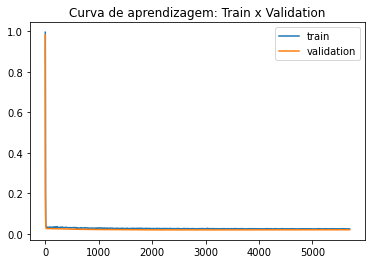

In [19]:
plt.plot(model.costs, label='train')
plt.plot(model.costs_val, label='validation')
plt.title("Curva de aprendizagem: Train x Validation")
plt.legend()

## 1.3. Desempenho training set

In [20]:
y_pred = model.predict(x_train_scaled)
y_pred = scaler_y.inverse(y_pred)


mre = MRE(y_train, y_pred)
RMSE = np.sqrt(MSE(y_train, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))


MRE: 0.6035854829370318
RMSE: 17.024373169986166


In [21]:
scaler_x.fit(x_train)
scaler_y.fit(y_train)

x_train_scaled  = scaler_x.transform(x_train)
x_val_scaled = scaler_x.transform(x_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_train)

In [22]:
model = MLP_1L(**best)

model.fit(x_train, y_train, x_val, y_val)
y_pred = model.predict(x_val)
y_pred = scaler_y.inverse(y_pred)


mre = MRE(y_test, y_pred)
RMSE = np.sqrt(MSE(y_test, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))

MRE: 90.28022559153679
RMSE: 2585.6030987887552


# 2. MLP para classificação 

## 2.1. Funções e Classes Auxiliares

In [23]:
def addOneColunm(x):
    return np.c_[np.ones(x.shape[0]), x[:, :]]

def accuracy(y, y_pred):
    a = np.count_nonzero((y == y_pred) == True)
    return a/len(y) * 100

def crossEntropy(y, pred_val):
    return  -np.mean(np.sum(y * np.log(pred_val), axis=1))

def linear(x):
    return x

def reLU(x):
    out = []
    out.append(np.array([max(0, u) for u in x[0]]))
    for i in range(1,x.shape[0]):
        out.append(np.array([max(0, u) for u in x[i]]))
    return np.array(out)

def deri_reLU(x):
    out = []
    out.append([1 if u>=0 else 0 for u in x[0]])
    for i in range(1,x.shape[0]):
        out.append([1 if u>=0 else 0 for u in x[i]])
    return np.array(out)

def fsigmoide(x):
    return 1/(1+np.exp(-x))

def ftangh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

def sigmoide(x):
    out = []
    out.append(np.array([fsigmoide(u) for u in x[0]]))
    for i in range(1,x.shape[0]):
        out.append(np.array([fsigmoide(u) for u in x[i]]))
    return np.array(out)

def deri_sigmoide(x):
    out = []
    out.append([fsigmoide(u) - fsigmoide(u)**2 for u in x[0]])
    for i in range(1,x.shape[0]):
        out.append([fsigmoide(u) - fsigmoide(u)**2 for u in x[i]])
    return np.array(out)

def tangh(x):
    out = []
    out.append(np.array([ftangh(u) for u in x[0]]))
    for i in range(1,x.shape[0]):
        out.append(np.array([ftangh(u) for u in x[i]]))
    return np.array(out)

def deri_tangh(x):
    out = []
    out.append([1 - ftangh(u)**2 for u in x[0]])
    for i in range(1,x.shape[0]):
        out.append([1 - ftangh(u)**2 for u in x[i]])
    return np.array(out)

def fsoftmax(x):
    num = np.exp(x)
    return num/np.sum(num)

def softmax(x, N):
    o1 = []
    for j in range(N):
        out = []
        for outNeur in x:
            out.append(outNeur[j])

        o1.append(fsoftmax(out))
    return np.array(o1)

def initBXavier(size):
    w = np.array([np.random.normal(0, np.sqrt(1/size)) for x in range(size)])
    w[0] = 0.01 
    return w

In [24]:
class Neural_Network:
    
    def __init__(self, Nh, dims, alpha, momentum, hiddenFunc, outFunc):
        self.Nh = Nh
        self.alpha = alpha
        self.M_delta = 0
        self.W_delta = 0
        self.momentum = momentum
        self.hiddenFunc = hiddenFunc
        self.outFunc = outFunc
        
        self.W = np.zeros([Nh, dims])
        for j in range(Nh):
            self.W[j,:] = initBXavier(dims)

        self.M = np.zeros([K, Nh+1])
        for j in range(K):
            self.M[j,:] = initBXavier(Nh+1)
    
    def forward(self, batch_x):
        u = self.W@batch_x.T
        if self.hiddenFunc == 'tangh':
            z = tangh(u)
        elif self.hiddenFunc == 'sigmoide':
            z = sigmoide(u)
        elif self.hiddenFunc == 'relu':
            z = reLU(u)

        z = np.r_[np.ones([1, batch_x.shape[0]]), z]

        r = self.M@z
        
        if self.outFunc == 'identidade':
            o1 = linear(r)
        elif self.outFunc == 'softmax':
            o1 = softmax(r, r.shape[1])
        
        self.u = u
        self.z = z
        return o1

    def backward(self, e, batch_x, mode):
        delta = -e
        if self.hiddenFunc == 'tangh':
            deri_u = deri_tangh(self.u)
        elif self.hiddenFunc == 'sigmoide':
            deri_u = deri_sigmoide(self.u)
        elif self.hiddenFunc == 'relu':
            deri_u = deri_reLU(self.u)
        
        if mode == "classification":
            delta = delta.T
            C = deri_u * (self.M[:, 1:self.Nh+1].T @ delta)
        else:
            delta = delta.reshape(1,-1)
            C = deri_u*(np.expand_dims(self.M[0][1:self.Nh+1], axis=0).T @ delta)

        self.M_delta = self.momentum*self.M_delta - self.alpha * delta @ self.z.T
        self.M = self.M + self.M_delta
                
        self.W_delta = self.momentum*self.W_delta - self.alpha * C @ batch_x
        self.W = self.W + self.W_delta

In [35]:
dataset = np.genfromtxt('./vowel.csv', delimiter=',')

X = dataset[:, 0:9]
y = dataset[:, dataset.shape[1]-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [36]:
X_scale = StandardScaler().fit(X_train)
encoder = OneHotEncoder(sparse=False)

X_train_norm = X_scale.transform(X_train)
y_train_encod = encoder.fit_transform(y_train.reshape(len(y_train), 1))

X_val_norm = X_scale.transform(X_val)
y_val_encod = encoder.fit_transform(y_val.reshape(len(y_val), 1))

X_train_norm = addOneColunm(X_train_norm)
X_val_norm = addOneColunm(X_val_norm)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Time: 1665.9897859096527

 hyperparameters of lower validation by random-search:
 N: 57 lr: 0.00035999999999999997

Accuracy of lower validation set: 90.40404040404042% 



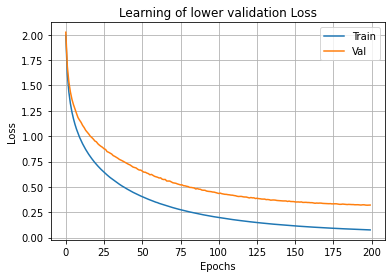

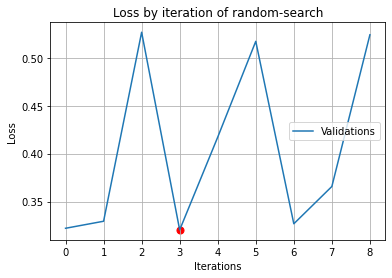

In [37]:
batch_size = 32
epochs = 200
K = 11 
mi = 0.9

loss_validations = []

history_loss_val = []
history_loss_train = []
acc_val = []

random_neurons = random.sample(range(50,150), 3)
random_leaning = random.sample(list(np.linspace(0.00001, 0.001, 100)), 3)

step=0

start = time.time()

for Nh in random_neurons:
    
    
    
    
    for alpha in random_leaning:
        
        loss_train = []
        loss_val = []

        
        net = Neural_Network(Nh, X_train_norm.shape[1], alpha, mi, hiddenFunc='tangh', outFunc='softmax')
        
        print(f'Step: {step}')

        for i in range(0, epochs):

        
            indices = np.random.permutation(X_train_norm.shape[0])

            
            for j in range(0,len(indices),batch_size):

                if j+batch_size <= len(X_train_norm):
                    batch_X = X_train_norm[indices[j:j+batch_size],:]
                    batch_y = y_train_encod[indices[j:j+batch_size]]
                else:
                    batch_X = X_train_norm[indices[j:],:]
                    batch_y = y_train_encod[indices[j:]] 

                
                o1 = net.forward(batch_X)

                e = (batch_y - o1)

                
                net.backward(e, batch_X, 'classification')

            
            pred_val = net.forward(X_val_norm)

            cross_entropy_val = crossEntropy(y_val_encod, pred_val)
            loss_val.append(cross_entropy_val)
            
            
            y_pred_val_class = np.argmax(pred_val, axis=1)
            acc = accuracy(y_val, y_pred_val_class)

            
            pred_train = net.forward(X_train_norm)

            cross_entropy_train = crossEntropy(y_train_encod, pred_train)
            loss_train.append(cross_entropy_train)
            
        
        loss_validations.append(cross_entropy_val) 
        history_loss_train.append(loss_train)
        history_loss_val.append(loss_val)
        acc_val.append(acc)
        step+=1

end = time.time()
print(f'Time: {end - start}')


mini = np.min(loss_validations)

index = loss_validations.index(mini)
p_neur = int(index/len(random_neurons))
p_lr = index - int(index/len(random_leaning)) * len(random_leaning)

print(f'\n hyperparameters of lower validation by random-search:\n N: {random_neurons[p_neur]} lr: {random_leaning[p_lr]}\n')

print(f'Accuracy of lower validation set: {acc_val[index]}% \n')


plt.plot(range(len(history_loss_train[index])), history_loss_train[index], label='Train')
plt.plot(range(len(history_loss_val[index])), history_loss_val[index], label='Val')
plt.title('Learning of lower validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")   
plt.grid(True)
plt.legend()
plt.show()


plt.plot(range(len(loss_validations)), loss_validations, label='Validations')
plt.scatter(index, loss_validations[index], s=50, c='red') # marca menor valor
plt.title('Loss by iteration of random-search')
plt.xlabel("Iterations")
plt.ylabel("Loss")   
plt.grid(True)
plt.legend()
plt.show()   

In [38]:
X_train = np.r_[X_train, X_val]
y_train = np.r_[y_train, y_val]

print(f'Sizes: \nX_train: {len(X_train)} X_test: {len(X_test)} total: {len(X)}')

X_scale = StandardScaler().fit(X_train)
encoder = OneHotEncoder(sparse=False)

X_train_norm = X_scale.transform(X_train)
y_train_encod = encoder.fit_transform(y_train.reshape(len(y_train), 1))

X_test_norm = X_scale.transform(X_test)
y_test_encod = encoder.fit_transform(y_test.reshape(len(y_test), 1))

X_train_norm = addOneColunm(X_train_norm)
X_test_norm = addOneColunm(X_test_norm)

Sizes: 
X_train: 792 X_test: 198 total: 990


In [40]:
W_delta = 0
M_delta = 0

Nh = random_neurons[p_neur]
alpha = random_leaning[p_lr]
    
net = Neural_Network(Nh, X_train_norm.shape[1], alpha, mi, hiddenFunc='tangh', outFunc='softmax')

for i in range(0, 500):

    
    indices = np.random.permutation(X_train_norm.shape[0])

    
    for j in range(0,len(indices),batch_size):

        if j+batch_size <= len(X_train_norm):
            batch_X = X_train_norm[indices[j:j+batch_size],:]
            batch_y = y_train_encod[indices[j:j+batch_size]]
        else:
            batch_X = X_train_norm[indices[j:],:]
            batch_y = y_train_encod[indices[j:]] 

         
        o1 = net.forward(batch_X)

        e = (batch_y - o1)

        
        net.backward(e, batch_X, 'classification')
                            

pred_train = net.forward(X_train_norm)
cross_entropy_train = crossEntropy(y_train_encod, pred_train)

y_pred_train_class = np.argmax(pred_train, axis=1)
acc_train = accuracy(y_train, y_pred_train_class)
            

pred_test = net.forward(X_test_norm)
cross_entropy_test = crossEntropy(y_test_encod, pred_test)

y_pred_test_class = np.argmax(pred_test, axis=1)
acc_test = accuracy(y_test, y_pred_test_class)

print(f'Accuracy of lower validation set from random-search:\nAccuracy: {acc_val[index]}% \n')
print('\n=======================================\n')
print(f'Metrics Train (Val + Train) set:\nAccuracy: {acc_train}%\n')
print('\n=======================================\n')
print(f'Metrics Test set:\nAccuracy: {acc_test}%\n')

Accuracy of lower validation set from random-search:
Accuracy: 90.40404040404042% 



Metrics Train (Val + Train) set:
Accuracy: 100.0%



Metrics Test set:
Accuracy: 94.94949494949495%

